In [51]:
import numpy as np
from constants import *
from scripts.scripts import *
from scripts.gdal_scripts import *
import geopandas as gp
from classes import *
import simplekml

import shapely as sp


In [58]:
def binify_df(df:pd.DataFrame, bins:tuple[Bin], column:str) -> pd.DataFrame:
    conditions, categories = [], []
    for bin in bins:
        conditions.append((df[column] >= bin.lower_bound) & (df[column] < bin.upper_bound))
        categories.append(bin.enum)
    df[column+"_s"] = np.select(conditions, categories)
    return df

def get_distance(
        coords:tuple[int,int,int,int]) -> float:
    """
    Must be (lat_1, lon_1, lat_2, lon_2)
    """
    import geopy.distance
    distance = geopy.distance.geodesic((coords[0], coords[1]), (coords[2], coords[3])).m
    return distance

def save_geodataframe(geo_df:gp.GeoDataFrame, file_name:str) -> None:
    file_path = SHP_PATH+file_name+'.shp.zip'
    geo_df.to_file(filename=file_path, driver='ESRI Shapefile', crs='EPSG:4326')
    print(f"Saved geo_df to {file_path}")

def open_shapefile(*, file_name:str):
    file_path = SHP_PATH+file_name+'.shp.zip'
    print(f"Opened {file_path}")
    return gp.read_file(file_path)

def shp_of_polygons_to_dict_of_bins(*, bins:tuple[Bin], shp:object=None, shp_file_name:str=None) -> dict:
    """
    Use shp or shp_file_name
    """
    if shp_file_name:
        shp = open_shapefile(file_name=shp_file_name)
    polygon_dict = {}
    for bin in bins:
        polygon_dict[bin.enum] = shp[shp['DN'] == bin.enum]["geometry"].to_dict()
    print("Converted shapefile to polygon dictionary")
    return polygon_dict

In [9]:
bm_dens_col_name = "bm_dens"
bm_dens_bins = (
    Bin(bm_dens_col_name, 1,"First bin", 0, 20, simplekml.Color.orange),
    Bin(bm_dens_col_name, 2,"Second bin", 20, 40, simplekml.Color.tomato),
    Bin(bm_dens_col_name, 3,"Third bin", 40,60, simplekml.Color.red),
    )

main_name = "only_bm_seg"
df = get_pandas_from_csv(csv_name=main_name,sep=",",index_col=0)
df = binify_df(df=df,bins=bm_dens_bins,column=bm_dens_col_name)

geo_df = dataframe_to_shp(input_df=df)
geo_df = geo_df.reset_index()
geo_df = geo_df.drop(columns=['index'])
save_geodataframe(
    geo_df=geo_df,
    file_name=main_name,
)

min_lon, min_lat, max_lon, max_lat = geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3]
width = get_distance(coords_1=(min_lat, min_lon), coords_2=(min_lat, max_lon))
height = get_distance(coords_1=(min_lat, min_lon), coords_2=(max_lat, min_lon))
print(f"geo_df is {round(width)} m in width and {round(height)} m in height")


Saved geo_df to shapefiles/only_bm_seg.shp.zip
geo_df is 7084 m in width and 1198 m in height


In [7]:
target_column = "bm_dens_s"
new_main_name = main_name+"-"+target_column+"-"
new_main_name_full = gdal_run_interpolation(
    input_shp_name=main_name,
    target_column=target_column,
    output_tif_name=new_main_name,
    algorithm="nearest",
    radius1=0.007,
    radius2=0.0005,
    width=int(width/10),
    height=int(height/10),
)

Options:  ['-of', 'Gtiff', '-ot', 'Byte', '-outsize', '708', '119', '-a', 'nearest:power=1:radius1=0.007:radius2=0.0005:', '-zfield', 'bm_dens_s']
Running interpolation on: shapefiles/only_bm_seg.shp.zip
Saving to: tif_files/only_bm_seg-bm_dens_s--nearest-0.007-0.0005.tif


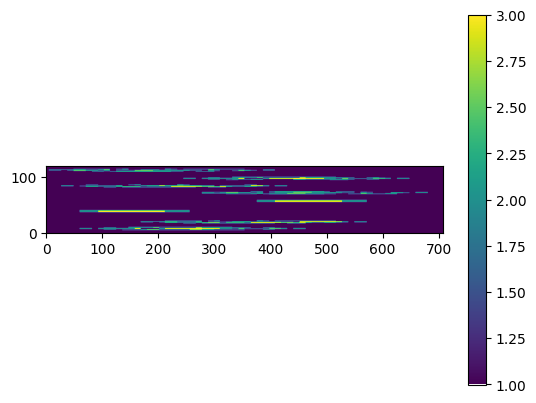

In [45]:
#gdal_print_metadata(tif_name=new_main_name_full)
plot_raster(tif_name=new_main_name_full)

In [8]:
make_polygons(
    input_tif=new_main_name_full,
    mask='none',
    options=["-mask",new_main_name_full])
# polygon_df = open_shapefile(file_name=new_main_name_full)
polygon_dict = shp_of_polygons_to_dict_of_bins(shp_file_name=new_main_name_full,bins=bm_dens_bins)

Opened shapefiles/only_bm_seg-bm_dens_s--nearest-0.007-0.0005.shp.zip


In [4]:
def make_kml(file_name:str, polygon_dict:dict, bins:tuple[Bin]) -> None:
    assert ".kml" not in file_name
    kml = simplekml.Kml()
    for bin in bins:
        multipolodd = kml.newmultigeometry(name="MultiPoly")
        for polygon in polygon_dict.values():
            pol = multipolodd.newpolygon(
                name="polygon",
                outerboundaryis=list(polygon.exterior.coords),
            )
            pol.style.polystyle.color = bin.colour
            pol.style.polystyle.outline = 0
    kml.save(file_name+".kml")
#simplekml.Color.tomato

In [2]:
make_kml(
    file_name="kml_file_2",
    polygon_dict=polygon_dict[2],
    bins=bm_dens_bins,
)

NameError: name 'make_kml' is not defined

In [ ]:
# z_field = "bm_dens"
# new_main_name = tif_name+"-"+z_field+"-"
# new_main_name_full = gdal_run_interpolation(
#     input_shp_name=tif_name,
#     target_column=z_field,
#     output_tif_name=new_main_name,
#     algorithm="average",
#     radius1=0.001,
#     radius2=0.0005,
#     width=int(width/10),
#     height=int(height/10),
#     # max_points=4,
#     # min_points=1,
#     max_points_per_quadrant=2,
#     min_points_per_quadrant=1,
# )
# from osgeo_utils.samples import ogr2ogr
# def main():
#   ogr2ogr.main(["","-f", "KML", "out75.kml", SHP_PATH+"new75.shp.zip","-simplify", "0.0001"])
# main()

In [5]:
main_name = "only_bm_seg"
shp = open_shapefile(file_name=main_name)

Opened shapefiles/only_bm_seg.shp.zip


In [10]:
# Buffer the points using a square cap style
#https://gis.stackexchange.com/questions/314949/creating-square-buffers-around-points-using-shapely
# Note cap_style: round = 1, flat = 2, square = 3
geo_df["buffer"] = shp["geometry"].buffer(0.00005, cap_style = 3)

C:\Users\thoma\AppData\Local\Temp\ipykernel_14884\3689846920.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_df["buffer"] = shp["geometry"].buffer(0.00005, cap_style = 3)


In [19]:
def make_kml_from_df(file_name:str, geo_df:gp.GeoDataFrame, bins:tuple[Bin], grouping_col:str) -> None:
    assert ".kml" not in file_name
    kml = simplekml.Kml()
    for bin in bins:
        multipolodd = kml.newmultigeometry(name="MultiPoly")
        for polygon in geo_df[geo_df[grouping_col] == bin.enum]["buffer"]:
            pol = multipolodd.newpolygon(
                name="polygon",
                outerboundaryis=list(polygon.exterior.coords),
            )
            pol.style.polystyle.color = bin.colour
            pol.style.polystyle.outline = 0
    kml.save(file_name+".kml")

In [20]:
make_kml_from_df(file_name="attempt1", geo_df=geo_df, bins=bm_dens_bins, grouping_col="bm_dens_s")

In [67]:
def make_kml_from_multipolygon(file_name:str, multi_poly:sp.MultiPolygon, bin:Bin) -> None:
    assert ".kml" not in file_name
    kml = simplekml.Kml()
    multipolodd = kml.newmultigeometry(name="MultiPoly")
    for polygon in multi_poly.geoms:
        pol = multipolodd.newpolygon(
            name="polygon",
            outerboundaryis=list(polygon.exterior.coords),
        )
        pol.style.polystyle.color = bin.colour
        pol.style.polystyle.outline = 0
    kml.save(file_name+".kml")


In [71]:
# from shapely.ops import unary_union
bin_1_union = sp.ops.unary_union(geo_df[geo_df["bm_dens_s"] == 1]["buffer"])

In [75]:
make_kml_from_multipolygon(file_name="attempt3", multi_poly=bin_1_union, bin=bm_dens_bins[0])

In [91]:
def unite_polygons(*, geo_df:gp.GeoDataFrame, grouping_col:str, bins:tuple[Bin]) -> dict[str,sp.MultiPolygon]:
    multipolygon_dict = dict()
    for bin in bins:
        key = "bin_"+str(bin.enum)+"_multipolygon"
        column = geo_df[geo_df[grouping_col] == bin.enum]["buffer"]
        multipolygon_dict[key] = sp.ops.unary_union(geo_df[geo_df[grouping_col] == bin.enum]["buffer"])
        print("Bin {}: uniting {} polygons to {} polygons".format(bin.enum, len(column), len(multipolygon_dict[key].geoms)))
    return multipolygon_dict

In [92]:
multipolygon_dict = unite_polygons(geo_df=geo_df, grouping_col="bm_dens_s",bins=bm_dens_bins)

Bin 1 Uniting 73264 polygons to 414 polygons
Bin 2 Uniting 5485 polygons to 514 polygons
Bin 3 Uniting 2851 polygons to 292 polygons


In [96]:
dir()

['Bin',
 'CSV_PATH',
 'In',
 'Out',
 'Point',
 'ROOT_DIR',
 'SHP_PATH',
 'TIF_PATH',
 '_',
 '_11',
 '_13',
 '_14',
 '_15',
 '_17',
 '_21',
 '_22',
 '_24',
 '_25',
 '_26',
 '_28',
 '_31',
 '_32',
 '_34',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_42',
 '_43',
 '_44',
 '_46',
 '_50',
 '_52',
 '_53',
 '_54',
 '_59',
 '_60',
 '_61',
 '_62',
 '_65',
 '_72',
 '_88',
 '_93',
 '_94',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__vsc_ipynb_file__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i52',
 '_i53',
 '_i54',
 '_i55',
 '_i56',
 '_

In [62]:
get_distance(coords=bin_3_union.geoms[4].bounds)

21.04669954354165